In [1]:
! pip install scipy
! pip install torch

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu124



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Training code

In [68]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import json
import torch

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [70]:
# Custom Dataset Class
class FlowersDataset(tf.keras.utils.Sequence):
    def __init__(self, image_dir, embedding_dir, batch_size=64, image_size=64):
        self.image_dir = image_dir
        self.embedding_dir = embedding_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_files = os.listdir(image_dir)
        self.embedding_files = os.listdir(embedding_dir)
        
    def __len__(self):
        return len(self.image_files) // self.batch_size
    
    def __getitem__(self, idx):
        batch_image_files = self.image_files[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_images = []
        batch_embeddings = []
        
        for image_file in batch_image_files:
            # Load and preprocess image
            img_path = os.path.join(self.image_dir, image_file)
            image = Image.open(img_path).convert("RGB")
            image = image.resize((self.image_size, self.image_size)) #  Image_Size= 64x64
            image = np.array(image, dtype=np.float32) / 127.5 - 1  # Normalize to [-1, 1]
            batch_images.append(image)
            
            # Load corresponding embedding
            embedding_file = image_file.replace('.jpg', '.npy')
            embedding_path = os.path.join(self.embedding_dir, embedding_file)
            embedding = np.load(embedding_path)
            batch_embeddings.append(embedding)
        
        return np.array(batch_embeddings), np.array(batch_images)

In [71]:
def get_embedding_dimension(embedding_dir):
    """
    Determine the embedding dimension by loading the first embedding file in the directory.
    """
    embedding_files = [f for f in os.listdir(embedding_dir) if f.endswith('.npy')]
    if not embedding_files:
        raise ValueError(f"No .npy files found in {embedding_dir}")
    
    first_embedding_file = os.path.join(embedding_dir, embedding_files[0])
    first_embedding = np.load(first_embedding_file)
    
    embedding_dim = first_embedding.shape[0]
    return embedding_dim

In [72]:
# Updated Generator
def make_generator_model(noise_dim, embedding_dim):
    combined_dim = noise_dim + embedding_dim
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4*4*512, use_bias=False, input_shape=(combined_dim,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((4, 4, 512)))

    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


In [73]:
# Updated Discriminator
def make_discriminator_model(embedding_dim):
    image_input = tf.keras.layers.Input(shape=(64, 64, 3))
    embedding_input = tf.keras.layers.Input(shape=(embedding_dim,))

    x = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(image_input)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)

    embedding_x = tf.keras.layers.Dense(128)(embedding_input)
    embedding_x = tf.keras.layers.LeakyReLU(0.2)(embedding_x)

    combined = tf.keras.layers.Concatenate()([x, embedding_x])

    x = tf.keras.layers.Dense(128)(combined)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=[image_input, embedding_input], outputs=output)

In [74]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [75]:
# Training step
def train_step(images, embeddings):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, noise_dim])
    combined_input = tf.concat([noise, embeddings], axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(combined_input, training=True)

        real_output = discriminator([images, embeddings], training=True)
        fake_output = discriminator([generated_images, embeddings], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [76]:
# Function to save models
def save_models(save_dir, epoch):
    generator.save(os.path.join(save_dir, f'generator_epoch_{epoch}.h5'))
    discriminator.save(os.path.join(save_dir, f'discriminator_epoch_{epoch}.h5'))
    print(f"Models saved for epoch {epoch}")

# Function to load models (for future inference)
def load_models(save_dir, epoch):
    generator = tf.keras.models.load_model(os.path.join(save_dir, f'generator_epoch_{epoch}.h5'))
    discriminator = tf.keras.models.load_model(os.path.join(save_dir, f'discriminator_epoch_{epoch}.h5'))
    return generator, discriminator

In [77]:
# Load pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

def preprocess_images_for_inception(images):
    images = tf.image.resize(images, (299, 299))
    images = preprocess_input(images)
    return images

In [78]:
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # Get InceptionV3 predictions
    preds = inception_model.predict(preprocess_images_for_inception(images))
    
    # Calculate mean KL divergence
    scores = []
    n_part = images.shape[0] // n_split
    for i in range(n_split):
        part = preds[i * n_part:(i+1) * n_part]
        kl = part * (np.log(part + eps) - np.log(np.expand_dims(np.mean(part, 0), 0) + eps))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    
    return np.mean(scores), np.std(scores)

In [79]:
def calculate_fid(real_images, generated_images):
    # Calculate activation statistics for real and generated images
    act1 = inception_model.predict(preprocess_images_for_inception(real_images))
    act2 = inception_model.predict(preprocess_images_for_inception(generated_images))
    
    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    # Calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # Check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # Calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

In [80]:
def evaluate_gan(generator, dataset, num_images=1000):
    # Generate images in batches
    generated_images = []
    real_images = []
    num_batches = num_images // BATCH_SIZE + (1 if num_images % BATCH_SIZE != 0 else 0)
    
    for _ in range(num_batches):
        embeddings, images = next(iter(dataset))
        batch_size = embeddings.shape[0]
        noise = tf.random.normal([batch_size, noise_dim])
        combined_input = tf.concat([noise, embeddings], axis=1)
        generated_batch = generator(combined_input, training=False)
        
        generated_images.append(generated_batch)
        real_images.append(images)
    
    generated_images = tf.concat(generated_images, axis=0)[:num_images]
    real_images = tf.concat(real_images, axis=0)[:num_images]
    
    # Calculate Inception Score
    is_mean, is_std = calculate_inception_score(generated_images)
    
    # Calculate FID
    fid = calculate_fid(real_images, generated_images)
    
    return is_mean, is_std, fid

In [81]:
# Training loop
def train(dataset, epochs, save_dir, eval_interval=10):
    generator_losses = []
    discriminator_losses = []
    os.makedirs(save_dir, exist_ok=True)
    for epoch in range(epochs):
        gen_losses_epoch = []
        disc_losses_epoch = []
        for embedding_batch, image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, embedding_batch)
            gen_losses_epoch.append(gen_loss.numpy())
            disc_losses_epoch.append(disc_loss.numpy())

        avg_gen_loss = np.mean(gen_losses_epoch)
        avg_disc_loss = np.mean(disc_losses_epoch)
        generator_losses.append(avg_gen_loss)
        discriminator_losses.append(avg_disc_loss)

        print(f'Epoch {epoch+1}, Gen Loss: {gen_loss.numpy():.4f}, Disc Loss: {disc_loss.numpy():.4f}')
        
        generate_and_save_images(generator, epoch + 1, seed, fixed_embeddings)

        if (epoch + 1) % eval_interval == 0:
            is_mean, is_std, fid = evaluate_gan(generator, dataset)
            print(f'Epoch {epoch+1}, Inception Score: {is_mean:.4f} ± {is_std:.4f}, FID: {fid:.4f}')
        
        if (epoch + 1) % 100 == 0:
            save_models(save_dir, epoch + 1) #Save model for every 100 epochs

    save_models(save_dir, 'final')
    save_losses(save_dir, generator_losses, discriminator_losses)
    # Final evaluation
    is_mean, is_std, fid = evaluate_gan(generator, dataset)
    print(f'Final Evaluation - Inception Score: {is_mean:.4f} ± {is_std:.4f}, FID: {fid:.4f}')
    return generator_losses, discriminator_losses


In [82]:
# Function to convert any float32 to float in the losses
def convert_to_float(obj):
    if isinstance(obj, np.float32):  # If the object is a float32, convert it to Python float
        return float(obj)
    elif isinstance(obj, list):  # If it's a list, apply the function recursively
        return [convert_to_float(item) for item in obj]
    elif isinstance(obj, dict):  # If it's a dictionary, apply it to all values
        return {key: convert_to_float(value) for key, value in obj.items()}
    else:
        return obj

In [83]:
# Function to save losses
def save_losses(save_dir, generator_losses, discriminator_losses):
    losses = {
        'generator': generator_losses,
        'discriminator': discriminator_losses
    }
    losses = convert_to_float(losses)
    with open(os.path.join(save_dir, 'losses.json'), 'w') as f:
        json.dump(losses, f)

In [84]:
# Updated generate_and_save_images function
def generate_and_save_images(model, epoch, test_input, test_embeddings):
    predictions_folder=r'C:\Predictions_Glove_raw'
    # Ensure the folder exists, if not create it
    os.makedirs(predictions_folder, exist_ok=True)
    image_filename = 'image_at_epoch_{:04d}.png'.format(epoch)
    image_save_path = os.path.join(predictions_folder, image_filename)
    combined_input = tf.concat([test_input, test_embeddings], axis=1)
    predictions = model(combined_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) * 0.5)  # Denormalize
        plt.axis('off')

    plt.savefig(image_save_path)
    plt.close()

In [85]:
def generate_images(generator, num_images, noise_dim, embedding_dim):
    # Generate random noise
    noise = tf.random.normal([num_images, noise_dim])
    
    # Generate random embeddings (in a real scenario, you'd use actual embeddings)
    random_embeddings = tf.random.normal([num_images, embedding_dim])
    
    # Concatenate noise and embeddings
    combined_input = tf.concat([noise, random_embeddings], axis=1)
    
    # Generate images
    generated_images = generator(combined_input, training=False)
    
    # Denormalize the images (assuming they were normalized to [-1, 1])
    generated_images = (generated_images + 1) / 2.0
    
    return generated_images

In [86]:
def load_losses(save_dir):
    with open(os.path.join(save_dir, 'losses.json'), 'r') as f:
        losses = json.load(f)
    return losses['generator'], losses['discriminator']

# Function to visualize losses
def plot_losses(generator_losses, discriminator_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

## Muril without proofread

In [21]:
# Main execution
BATCH_SIZE = 64
noise_dim = 100
embedding_dim = 768  # This should match your actual embedding dimension

# Create the models
generator = make_generator_model(noise_dim, embedding_dim)
discriminator = make_discriminator_model(embedding_dim)

# Prepare the dataset
dataset = FlowersDataset(
    image_dir=r"C:\Dataset\Images", 
    embedding_dir=r"C:\Dataset\tamil_embeddings_300_raw",
    batch_size=BATCH_SIZE
)

# We'll reuse this seed and fixed embeddings to visualize progress
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
fixed_embeddings = tf.random.normal([num_examples_to_generate, embedding_dim])

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
save_dir= r'Model_raw_500'
epochs=500

In [72]:
# Start training
generator_losses, discriminator_losses = train(dataset,epochs=epochs, save_dir=save_dir, eval_interval=100)

Epoch 1, Gen Loss: 0.9423, Disc Loss: 0.6481
Epoch 2, Gen Loss: 2.2701, Disc Loss: 0.1572
Epoch 3, Gen Loss: 3.0866, Disc Loss: 0.0758
Epoch 4, Gen Loss: 2.7004, Disc Loss: 0.0869
Epoch 5, Gen Loss: 3.3212, Disc Loss: 0.0654
Epoch 6, Gen Loss: 2.6898, Disc Loss: 0.1071
Epoch 7, Gen Loss: 2.9251, Disc Loss: 0.0969
Epoch 8, Gen Loss: 2.9628, Disc Loss: 0.0999
Epoch 9, Gen Loss: 3.6309, Disc Loss: 0.0501
Epoch 10, Gen Loss: 3.9324, Disc Loss: 0.0341
Epoch 11, Gen Loss: 4.0774, Disc Loss: 0.0339
Epoch 12, Gen Loss: 4.0231, Disc Loss: 0.0505
Epoch 13, Gen Loss: 3.9357, Disc Loss: 0.0627
Epoch 14, Gen Loss: 3.8213, Disc Loss: 0.0983
Epoch 15, Gen Loss: 4.4856, Disc Loss: 0.0466
Epoch 16, Gen Loss: 5.0545, Disc Loss: 0.0598
Epoch 17, Gen Loss: 4.4916, Disc Loss: 0.0456
Epoch 18, Gen Loss: 4.5333, Disc Loss: 0.0339
Epoch 19, Gen Loss: 5.5555, Disc Loss: 0.0163
Epoch 20, Gen Loss: 4.7637, Disc Loss: 0.0189
Epoch 21, Gen Loss: 5.0790, Disc Loss: 0.0177
Epoch 22, Gen Loss: 4.8153, Disc Loss: 0.03

C:\Users\student\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


32/32 [==============================] - 17s 527ms/step
Epoch 200, Inception Score: 6464342220509020160.0000 ± inf, FID: 46.1609
Models saved for epoch 200
Epoch 201, Gen Loss: 3.2022, Disc Loss: 0.2384
Epoch 202, Gen Loss: 4.2331, Disc Loss: 0.2807
Epoch 203, Gen Loss: 4.0085, Disc Loss: 0.6926
Epoch 204, Gen Loss: 4.9656, Disc Loss: 0.8999
Epoch 205, Gen Loss: 5.1153, Disc Loss: 0.6032
Epoch 206, Gen Loss: 3.7882, Disc Loss: 0.4041
Epoch 207, Gen Loss: 3.3751, Disc Loss: 0.3501
Epoch 208, Gen Loss: 4.1107, Disc Loss: 0.4002
Epoch 209, Gen Loss: 4.4014, Disc Loss: 0.2496
Epoch 210, Gen Loss: 4.2818, Disc Loss: 0.1980
Epoch 211, Gen Loss: 6.2316, Disc Loss: 0.2209
Epoch 212, Gen Loss: 5.2116, Disc Loss: 0.1762
Epoch 213, Gen Loss: 6.7231, Disc Loss: 0.1270
Epoch 214, Gen Loss: 5.0905, Disc Loss: 0.2075
Epoch 215, Gen Loss: 5.1171, Disc Loss: 0.2027
Epoch 216, Gen Loss: 5.0839, Disc Loss: 0.2084
Epoch 217, Gen Loss: 5.2993, Disc Loss: 0.1733
Epoch 218, Gen Loss: 4.8821, Disc Loss: 0.175

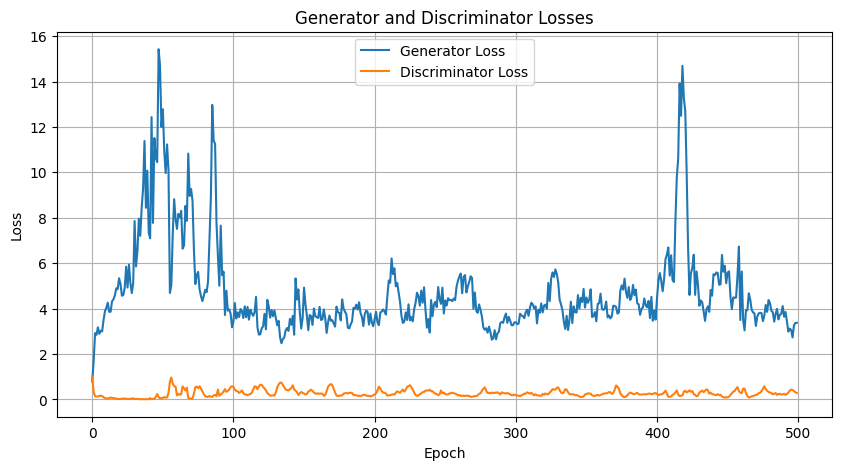

32/32 [==============================] - 16s 479ms/step


C:\Users\student\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


32/32 [==============================] - 16s 485ms/step
Loaded Model Evaluation - Inception Score: 37575489640097246705876992.0000 ± inf, FID: 49.1608


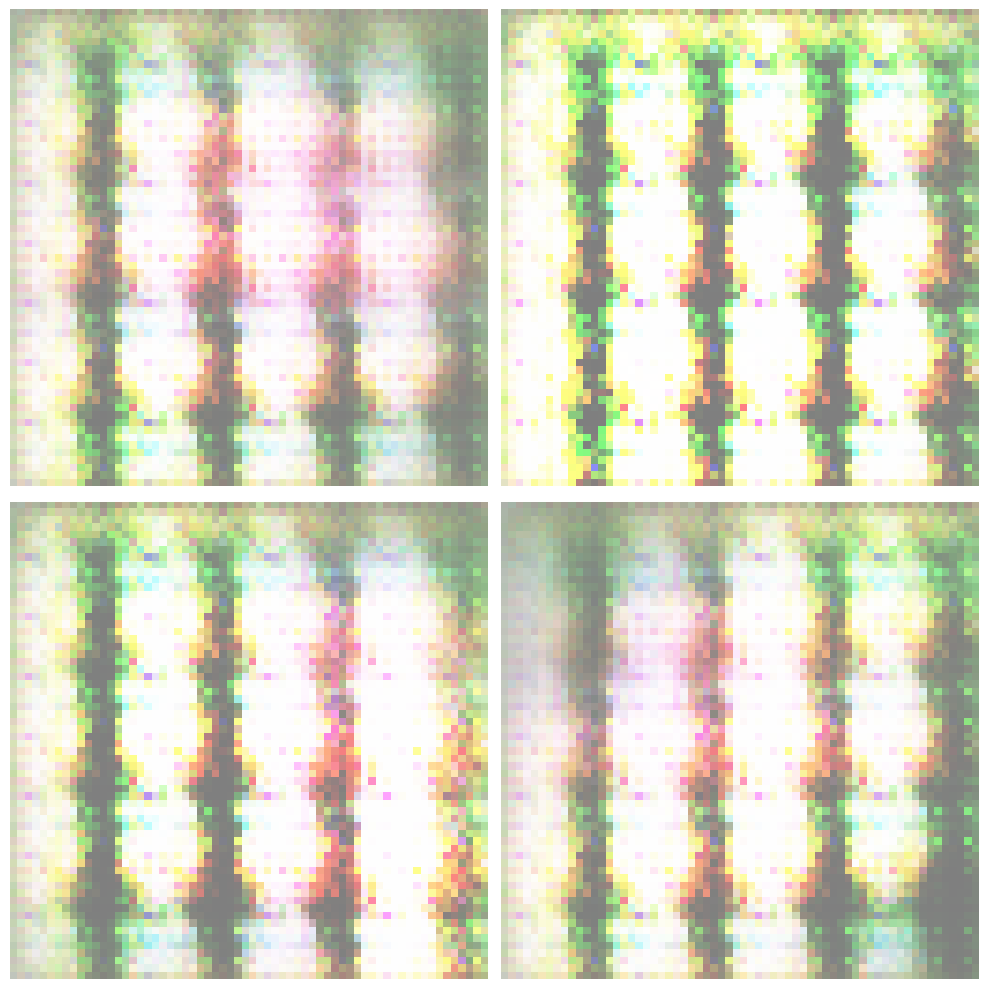

In [22]:
# Load the saved model and losses
loaded_generator, loaded_discriminator = load_models(save_dir, 'final')
loaded_gen_losses, loaded_disc_losses = load_losses(save_dir)

# Plot the losses
plot_losses(loaded_gen_losses, loaded_disc_losses)

# Evaluate the loaded model
is_mean, is_std, fid = evaluate_gan(loaded_generator, dataset)
print(f'Loaded Model Evaluation - Inception Score: {is_mean:.4f} ± {is_std:.4f}, FID: {fid:.4f}')

# Generate and display new images
new_images = generate_images(loaded_generator, 4, noise_dim, embedding_dim)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, img in enumerate(new_images):
    ax = axs[i//2, i%2]
    ax.imshow((img.numpy() + 1) * 0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Muril with Proofread

In [24]:
# Main execution
BATCH_SIZE = 64
noise_dim = 100
embedding_dim = 768  # This should match your actual embedding dimension

# Create the models
generator = make_generator_model(noise_dim, embedding_dim)
discriminator = make_discriminator_model(embedding_dim)

# Prepare the dataset
dataset = FlowersDataset(
    image_dir=r"C:\Dataset\Images", 
    embedding_dir=r"C:\Dataset\embeddings_300_proofread",
    batch_size=BATCH_SIZE
)

# We'll reuse this seed and fixed embeddings to visualize progress
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
fixed_embeddings = tf.random.normal([num_examples_to_generate, embedding_dim])

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
save_dir= r'Model_proofread_500'
epochs=500

In [25]:
# Start training
generator_losses, discriminator_losses = train(dataset,epochs=epochs, save_dir=save_dir, eval_interval=100)

C:\Users\student\AppData\Roaming\Python\Python39\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Gen Loss: 1.3184, Disc Loss: 0.5251
Epoch 2, Gen Loss: 2.3087, Disc Loss: 0.1483
Epoch 3, Gen Loss: 2.8195, Disc Loss: 0.0899
Epoch 4, Gen Loss: 3.4261, Disc Loss: 0.0784
Epoch 5, Gen Loss: 3.1998, Disc Loss: 0.0769
Epoch 6, Gen Loss: 3.6887, Disc Loss: 0.0582
Epoch 7, Gen Loss: 3.5911, Disc Loss: 0.0632
Epoch 8, Gen Loss: 3.8784, Disc Loss: 0.0654
Epoch 9, Gen Loss: 3.4903, Disc Loss: 0.0725
Epoch 10, Gen Loss: 3.6823, Disc Loss: 0.0501
Epoch 11, Gen Loss: 3.6693, Disc Loss: 0.0461
Epoch 12, Gen Loss: 3.2310, Disc Loss: 0.0627
Epoch 13, Gen Loss: 3.6121, Disc Loss: 0.0469
Epoch 14, Gen Loss: 4.4093, Disc Loss: 0.0216
Epoch 15, Gen Loss: 4.5397, Disc Loss: 0.0215
Epoch 16, Gen Loss: 5.0017, Disc Loss: 0.0147
Epoch 17, Gen Loss: 4.6248, Disc Loss: 0.0176
Epoch 18, Gen Loss: 5.6299, Disc Loss: 0.0121
Epoch 19, Gen Loss: 4.7450, Disc Loss: 0.0169
Epoch 20, Gen Loss: 5.3336, Disc Loss: 0.0134
Epoch 21, Gen Loss: 4.3993, Disc Loss: 0.0239
Epoch 22, Gen Loss: 5.4153, Disc Loss: 0.02

C:\Users\student\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 101, Gen Loss: 4.5416, Disc Loss: 0.2181
Epoch 102, Gen Loss: 5.9797, Disc Loss: 0.2223
Epoch 103, Gen Loss: 7.1880, Disc Loss: 0.1949
Epoch 104, Gen Loss: 5.6009, Disc Loss: 0.1339
Epoch 105, Gen Loss: 4.3215, Disc Loss: 0.2177
Epoch 106, Gen Loss: 5.2950, Disc Loss: 0.2351
Epoch 107, Gen Loss: 5.3845, Disc Loss: 0.1189
Epoch 108, Gen Loss: 5.3144, Disc Loss: 0.2359
Epoch 109, Gen Loss: 4.2097, Disc Loss: 0.1655
Epoch 110, Gen Loss: 4.1569, Disc Loss: 0.1988
Epoch 111, Gen Loss: 5.0049, Disc Loss: 0.1645
Epoch 112, Gen Loss: 5.9197, Disc Loss: 0.0912
Epoch 113, Gen Loss: 4.2392, Disc Loss: 0.2258
Epoch 114, Gen Loss: 5.4923, Disc Loss: 0.1512
Epoch 115, Gen Loss: 5.2321, Disc Loss: 0.4434
Epoch 116, Gen Loss: 4.9462, Disc Loss: 0.5576
Epoch 117, Gen Loss: 4.0186, Disc Loss: 0.7874
Epoch 118, Gen Loss: 3.6092, Disc Loss: 0.5158
Epoch 119, Gen Loss: 4.4916, Disc Loss: 0.2851
Epoch 120, Gen Loss: 6.0596, Disc Loss: 0.4652
Epoch 121, Gen Loss: 4.3259, Disc Loss: 0.4534
Epoch 122, Ge

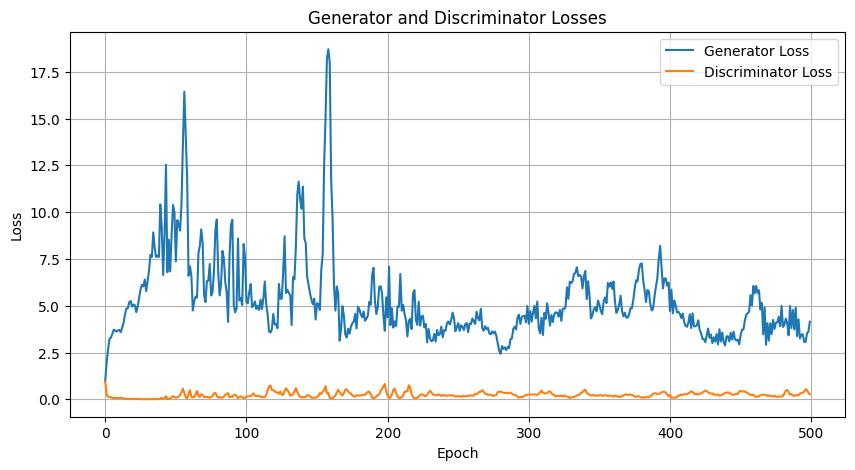

32/32 [==============================] - 18s 552ms/step
Loaded Model Evaluation - Inception Score: 31282540.0000 ± 29133576.0000, FID: 11.5919


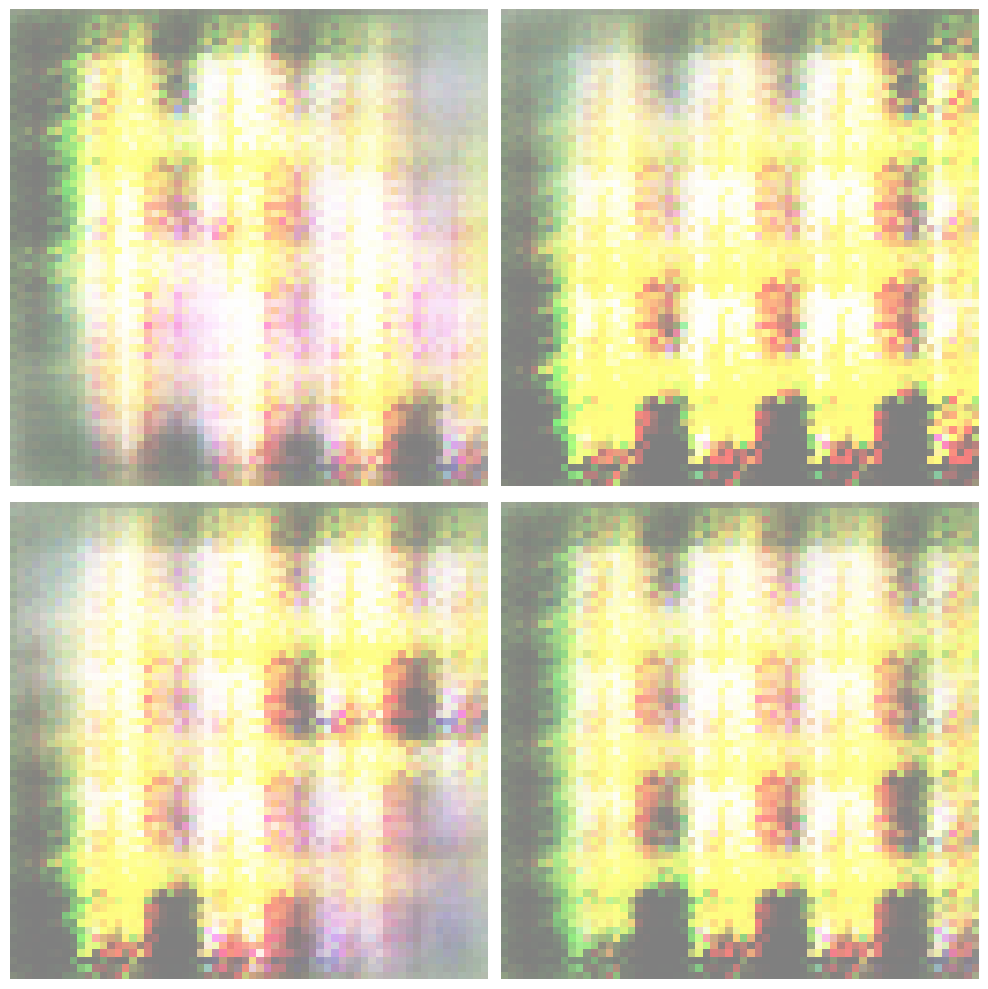

In [26]:
# Load the saved model and losses
loaded_generator, loaded_discriminator = load_models(save_dir, 'final')
loaded_gen_losses, loaded_disc_losses = load_losses(save_dir)

# Plot the losses
plot_losses(loaded_gen_losses, loaded_disc_losses)

# Evaluate the loaded model
is_mean, is_std, fid = evaluate_gan(loaded_generator, dataset)
print(f'Loaded Model Evaluation - Inception Score: {is_mean:.4f} ± {is_std:.4f}, FID: {fid:.4f}')

# Generate and display new images
new_images = generate_images(loaded_generator, 4, noise_dim, embedding_dim)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, img in enumerate(new_images):
    ax = axs[i//2, i%2]
    ax.imshow((img.numpy() + 1) * 0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()

## FastText with Proofread

In [17]:
# Main execution
BATCH_SIZE = 64
noise_dim = 100
embedding_dim = 300  # This should match your actual embedding dimension

# Create the models
generator = make_generator_model(noise_dim, embedding_dim)
discriminator = make_discriminator_model(embedding_dim)

# Prepare the dataset
dataset = FlowersDataset(
    image_dir=r"C:\Dataset\Images", 
    embedding_dir=r"C:\Dataset\embeddings_300_proofread_fasttext\embeddings_300_proofread_fasttext",
    batch_size=BATCH_SIZE
)

# We'll reuse this seed and fixed embeddings to visualize progress
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
fixed_embeddings = tf.random.normal([num_examples_to_generate, embedding_dim])

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
save_dir= r'Model_fasttext_proofread_500'
epochs=500

In [18]:
# Start training
generator_losses, discriminator_losses = train(dataset,epochs=epochs, save_dir=save_dir, eval_interval=100)

C:\Users\student\AppData\Roaming\Python\Python39\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Gen Loss: 0.8743, Disc Loss: 0.7544
Epoch 2, Gen Loss: 2.1603, Disc Loss: 0.2326
Epoch 3, Gen Loss: 2.8995, Disc Loss: 0.1336
Epoch 4, Gen Loss: 2.3074, Disc Loss: 0.1554
Epoch 5, Gen Loss: 3.0423, Disc Loss: 0.1592
Epoch 6, Gen Loss: 2.7702, Disc Loss: 0.2005
Epoch 7, Gen Loss: 3.3851, Disc Loss: 0.1503
Epoch 8, Gen Loss: 3.3028, Disc Loss: 0.0948
Epoch 9, Gen Loss: 3.6560, Disc Loss: 0.0622
Epoch 10, Gen Loss: 3.2313, Disc Loss: 0.0816
Epoch 11, Gen Loss: 3.1702, Disc Loss: 0.1458
Epoch 12, Gen Loss: 2.9596, Disc Loss: 0.2200
Epoch 13, Gen Loss: 3.3279, Disc Loss: 0.1703
Epoch 14, Gen Loss: 3.3841, Disc Loss: 0.1339
Epoch 15, Gen Loss: 3.3134, Disc Loss: 0.1969
Epoch 16, Gen Loss: 3.0727, Disc Loss: 0.1378
Epoch 17, Gen Loss: 3.1615, Disc Loss: 0.1151
Epoch 18, Gen Loss: 3.9475, Disc Loss: 0.1192
Epoch 19, Gen Loss: 3.0547, Disc Loss: 0.1307
Epoch 20, Gen Loss: 2.2167, Disc Loss: 0.1714
Epoch 21, Gen Loss: 5.6237, Disc Loss: 0.0128
Epoch 22, Gen Loss: 4.7862, Disc Loss: 0.01

C:\Users\student\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 101, Gen Loss: 5.5097, Disc Loss: 0.1877
Epoch 102, Gen Loss: 4.6623, Disc Loss: 0.0903
Epoch 103, Gen Loss: 4.7615, Disc Loss: 0.0563
Epoch 104, Gen Loss: 3.9234, Disc Loss: 0.1345
Epoch 105, Gen Loss: 6.0975, Disc Loss: 0.2336
Epoch 106, Gen Loss: 7.0021, Disc Loss: 0.2354
Epoch 107, Gen Loss: 7.9551, Disc Loss: 0.1199
Epoch 108, Gen Loss: 5.8093, Disc Loss: 0.0367
Epoch 109, Gen Loss: 6.0593, Disc Loss: 0.0257
Epoch 110, Gen Loss: 5.0892, Disc Loss: 0.0456
Epoch 111, Gen Loss: 7.0749, Disc Loss: 0.0985
Epoch 112, Gen Loss: 4.6675, Disc Loss: 0.1174
Epoch 113, Gen Loss: 6.4454, Disc Loss: 0.1273
Epoch 114, Gen Loss: 7.7248, Disc Loss: 0.0796
Epoch 115, Gen Loss: 9.3388, Disc Loss: 0.0453
Epoch 116, Gen Loss: 9.0228, Disc Loss: 0.0664
Epoch 117, Gen Loss: 8.3977, Disc Loss: 0.1027
Epoch 118, Gen Loss: 8.8315, Disc Loss: 0.0730
Epoch 119, Gen Loss: 9.7871, Disc Loss: 0.0404
Epoch 120, Gen Loss: 11.4097, Disc Loss: 0.0380
Epoch 121, Gen Loss: 11.0483, Disc Loss: 0.0433
Epoch 122, 

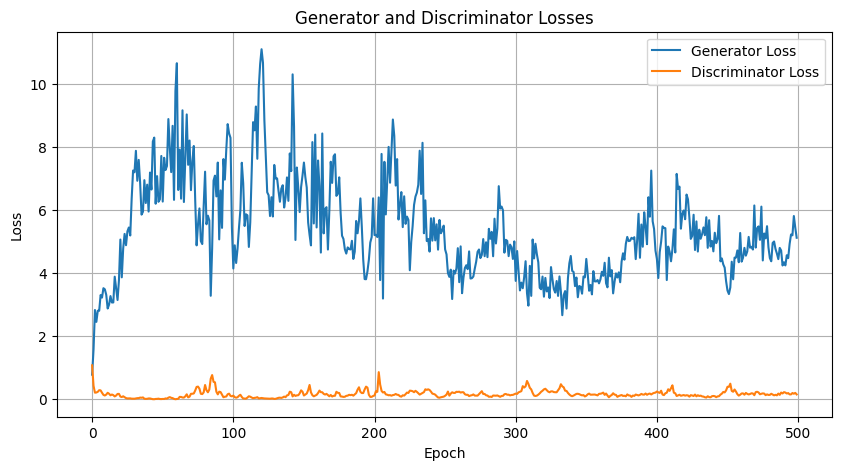

32/32 [==============================] - 16s 489ms/step
Loaded Model Evaluation - Inception Score: 7186333.5000 ± 12192042.0000, FID: 12.4062


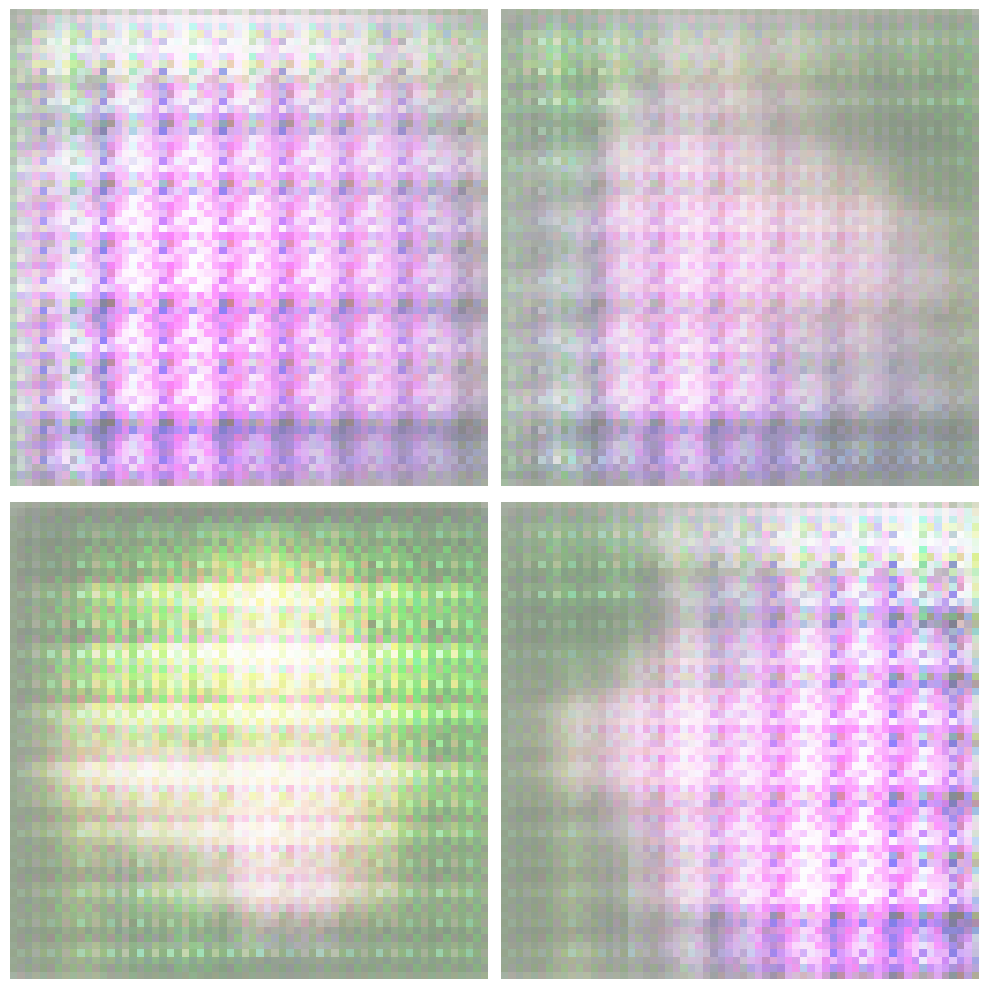

In [21]:
# Load the saved model and losses
loaded_generator, loaded_discriminator = load_models(save_dir, 'final')
loaded_gen_losses, loaded_disc_losses = load_losses(save_dir)

# Plot the losses
plot_losses(loaded_gen_losses, loaded_disc_losses)

# Evaluate the loaded model
is_mean, is_std, fid = evaluate_gan(loaded_generator, dataset)
print(f'Loaded Model Evaluation - Inception Score: {is_mean:.4f} ± {is_std:.4f}, FID: {fid:.4f}')

# Generate and display new images
new_images = generate_images(loaded_generator, 4, noise_dim, embedding_dim)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, img in enumerate(new_images):
    ax = axs[i//2, i%2]
    ax.imshow((img.numpy() + 1) * 0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()

## FastText without Proofread

In [40]:
# Main execution
BATCH_SIZE = 64
noise_dim = 100
embedding_dim = 300  # This should match your actual embedding dimension

# Create the models
generator = make_generator_model(noise_dim, embedding_dim)
discriminator = make_discriminator_model(embedding_dim)

# Prepare the dataset
dataset = FlowersDataset(
    image_dir=r"C:\Dataset\Images", 
    embedding_dir=r"C:\Dataset\embeddings_300_raw_fasttext",
    batch_size=BATCH_SIZE
)

# We'll reuse this seed and fixed embeddings to visualize progress
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
fixed_embeddings = tf.random.normal([num_examples_to_generate, embedding_dim])

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
save_dir= r'Model_fasttext_raw_500'
epochs=500

In [41]:
# Start training
generator_losses, discriminator_losses = train(dataset,epochs=epochs, save_dir=save_dir, eval_interval=100)

Epoch 1, Gen Loss: 0.9051, Disc Loss: 0.8033
Epoch 2, Gen Loss: 1.6444, Disc Loss: 0.3507
Epoch 3, Gen Loss: 2.1945, Disc Loss: 0.2096
Epoch 4, Gen Loss: 2.3863, Disc Loss: 0.1643
Epoch 5, Gen Loss: 3.1977, Disc Loss: 0.1020
Epoch 6, Gen Loss: 2.4584, Disc Loss: 0.1305
Epoch 7, Gen Loss: 2.6192, Disc Loss: 0.2141
Epoch 8, Gen Loss: 1.9633, Disc Loss: 0.3520
Epoch 9, Gen Loss: 2.8800, Disc Loss: 0.2849
Epoch 10, Gen Loss: 2.7530, Disc Loss: 0.2489
Epoch 11, Gen Loss: 3.2532, Disc Loss: 0.2439
Epoch 12, Gen Loss: 3.4648, Disc Loss: 0.2304
Epoch 13, Gen Loss: 3.6523, Disc Loss: 0.1328
Epoch 14, Gen Loss: 4.4980, Disc Loss: 0.0422
Epoch 15, Gen Loss: 4.2591, Disc Loss: 0.0286
Epoch 16, Gen Loss: 4.8950, Disc Loss: 0.0301
Epoch 17, Gen Loss: 4.7531, Disc Loss: 0.0271
Epoch 18, Gen Loss: 4.8098, Disc Loss: 0.0238
Epoch 19, Gen Loss: 4.5221, Disc Loss: 0.0298
Epoch 20, Gen Loss: 5.1302, Disc Loss: 0.0506
Epoch 21, Gen Loss: 4.3838, Disc Loss: 0.0799
Epoch 22, Gen Loss: 3.5384, Disc Loss: 0.10

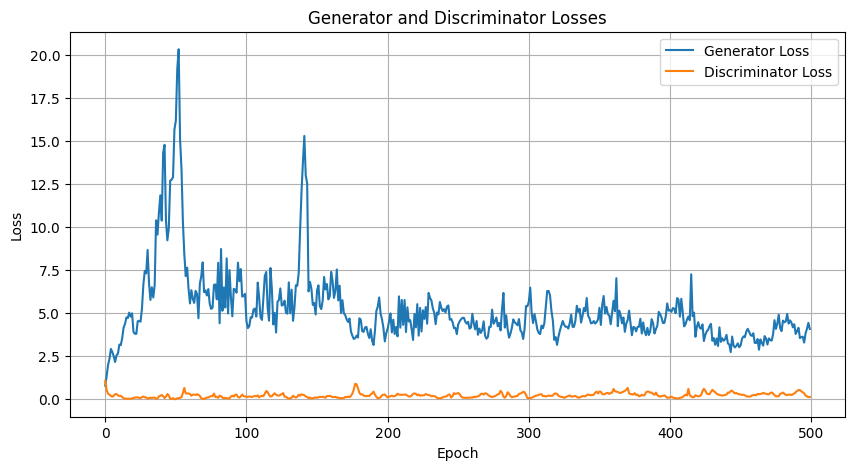

32/32 [==============================] - 74s 2s/step
Loaded Model Evaluation - Inception Score: 1542239.7500 ± 444679.5625, FID: 7.3187


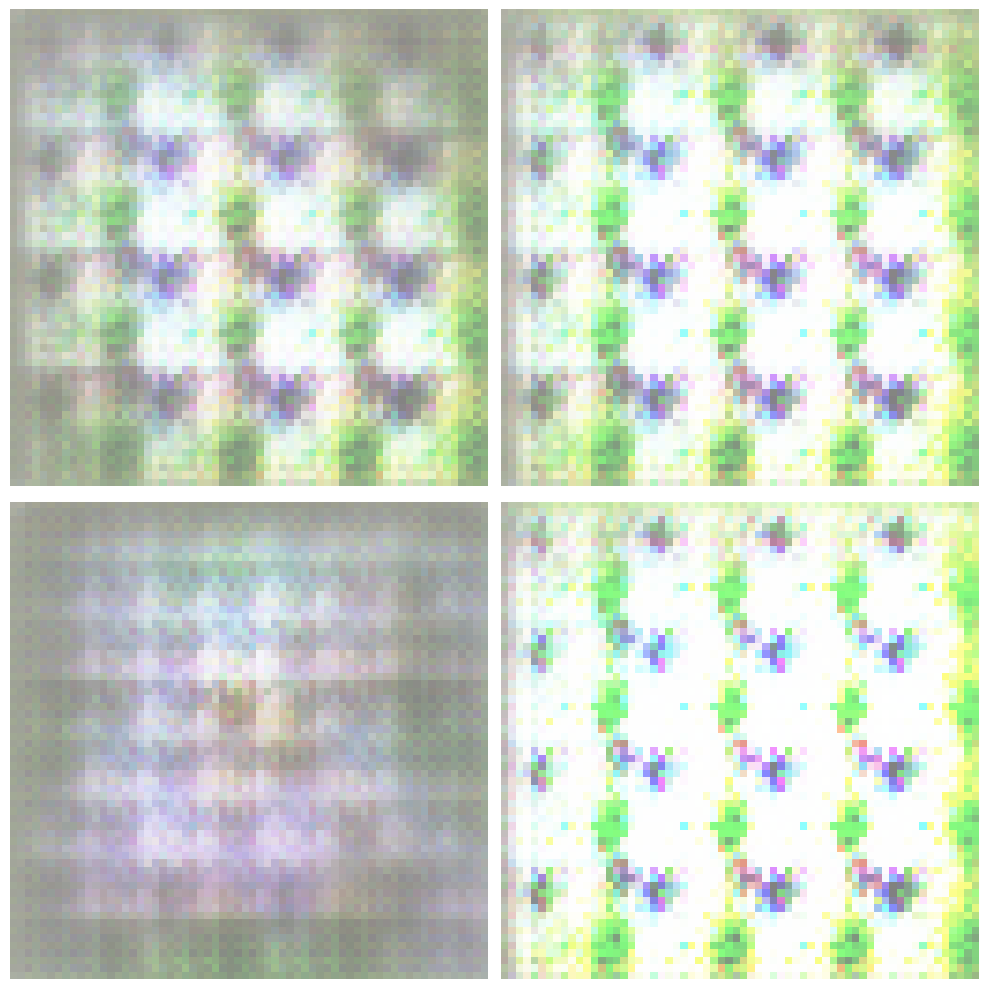

In [42]:
# Load the saved model and losses
loaded_generator, loaded_discriminator = load_models(save_dir, 'final')
loaded_gen_losses, loaded_disc_losses = load_losses(save_dir)

# Plot the losses
plot_losses(loaded_gen_losses, loaded_disc_losses)

# Evaluate the loaded model
is_mean, is_std, fid = evaluate_gan(loaded_generator, dataset)
print(f'Loaded Model Evaluation - Inception Score: {is_mean:.4f} ± {is_std:.4f}, FID: {fid:.4f}')

# Generate and display new images
new_images = generate_images(loaded_generator, 4, noise_dim, embedding_dim)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, img in enumerate(new_images):
    ax = axs[i//2, i%2]
    ax.imshow((img.numpy() + 1) * 0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Glove with Proofread

In [64]:
# Main execution
BATCH_SIZE = 64
noise_dim = 100
embedding_dir=r"C:\Dataset\embeddings_300_proofread_glove\embeddings_300_proofread_glove"
# Determine embedding dimension
embedding_dim = get_embedding_dimension(embedding_dir)

# Create the models
generator = make_generator_model(noise_dim, embedding_dim)
discriminator = make_discriminator_model(embedding_dim)

# Prepare the dataset
dataset = FlowersDataset(
    image_dir=r"C:\Dataset\Images", 
    embedding_dir=r"C:\Dataset\embeddings_300_proofread_glove\embeddings_300_proofread_glove",
    batch_size=BATCH_SIZE
)

# We'll reuse this seed and fixed embeddings to visualize progress
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
fixed_embeddings = tf.random.normal([num_examples_to_generate, embedding_dim])

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
save_dir= r'Model_glove_proofread_500'
epochs=500

In [65]:
# Start training
generator_losses, discriminator_losses = train(dataset,epochs=epochs, save_dir=save_dir, eval_interval=100)

Epoch 1, Gen Loss: 0.8235, Disc Loss: 0.7614
Epoch 2, Gen Loss: 1.8093, Disc Loss: 0.2956
Epoch 3, Gen Loss: 1.9831, Disc Loss: 0.2346
Epoch 4, Gen Loss: 2.2179, Disc Loss: 0.2436
Epoch 5, Gen Loss: 2.1763, Disc Loss: 0.2902
Epoch 6, Gen Loss: 2.9071, Disc Loss: 0.1911
Epoch 7, Gen Loss: 2.6600, Disc Loss: 0.1578
Epoch 8, Gen Loss: 2.8171, Disc Loss: 0.2195
Epoch 9, Gen Loss: 2.6027, Disc Loss: 0.2831
Epoch 10, Gen Loss: 2.5008, Disc Loss: 0.2733
Epoch 11, Gen Loss: 2.7308, Disc Loss: 0.2698
Epoch 12, Gen Loss: 3.2541, Disc Loss: 0.1912
Epoch 13, Gen Loss: 3.1403, Disc Loss: 0.1561
Epoch 14, Gen Loss: 3.0554, Disc Loss: 0.1390
Epoch 15, Gen Loss: 2.6345, Disc Loss: 0.1355
Epoch 16, Gen Loss: 3.2143, Disc Loss: 0.1037
Epoch 17, Gen Loss: 3.8301, Disc Loss: 0.0428
Epoch 18, Gen Loss: 3.4238, Disc Loss: 0.0553
Epoch 19, Gen Loss: 3.0649, Disc Loss: 0.0748
Epoch 20, Gen Loss: 4.3069, Disc Loss: 0.0205
Epoch 21, Gen Loss: 4.0019, Disc Loss: 0.0258
Epoch 22, Gen Loss: 4.1716, Disc Loss: 0.02

C:\Users\student\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


32/32 [==============================] - 17s 535ms/step
Epoch 200, Inception Score: 262065110835035503591424.0000 ± inf, FID: 55.4960
Models saved for epoch 200
Epoch 201, Gen Loss: 3.2345, Disc Loss: 0.2058
Epoch 202, Gen Loss: 4.8928, Disc Loss: 0.2388
Epoch 203, Gen Loss: 3.5853, Disc Loss: 0.2094
Epoch 204, Gen Loss: 3.5836, Disc Loss: 0.4261
Epoch 205, Gen Loss: 3.6317, Disc Loss: 0.5544
Epoch 206, Gen Loss: 2.8595, Disc Loss: 0.5789
Epoch 207, Gen Loss: 2.6135, Disc Loss: 0.7625
Epoch 208, Gen Loss: 3.6965, Disc Loss: 0.7014
Epoch 209, Gen Loss: 3.9029, Disc Loss: 0.3211
Epoch 210, Gen Loss: 3.9113, Disc Loss: 0.2319
Epoch 211, Gen Loss: 3.7381, Disc Loss: 0.3229
Epoch 212, Gen Loss: 3.9605, Disc Loss: 0.7790
Epoch 213, Gen Loss: 3.4367, Disc Loss: 0.7267
Epoch 214, Gen Loss: 2.8490, Disc Loss: 0.5331
Epoch 215, Gen Loss: 3.7409, Disc Loss: 0.2186
Epoch 216, Gen Loss: 4.3337, Disc Loss: 0.1388
Epoch 217, Gen Loss: 3.7344, Disc Loss: 0.1383
Epoch 218, Gen Loss: 3.7514, Disc Loss: 

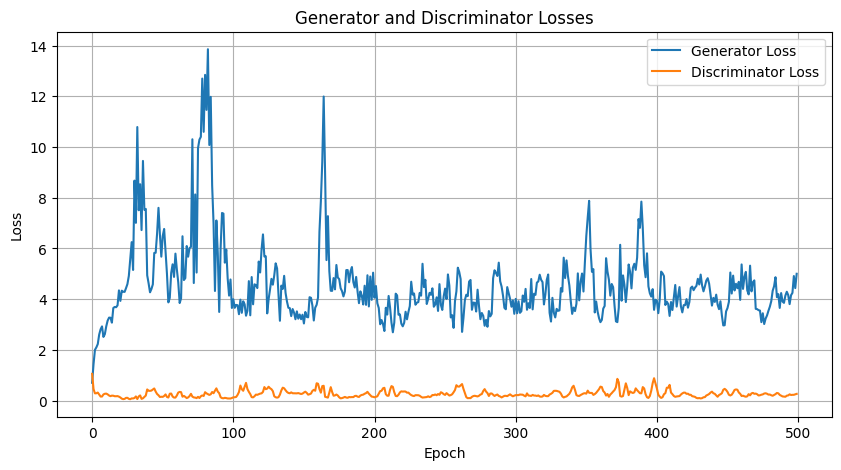

32/32 [==============================] - 17s 531ms/step
Loaded Model Evaluation - Inception Score: 2994378905881673728.0000 ± 5446593026153512960.0000, FID: 29.2469


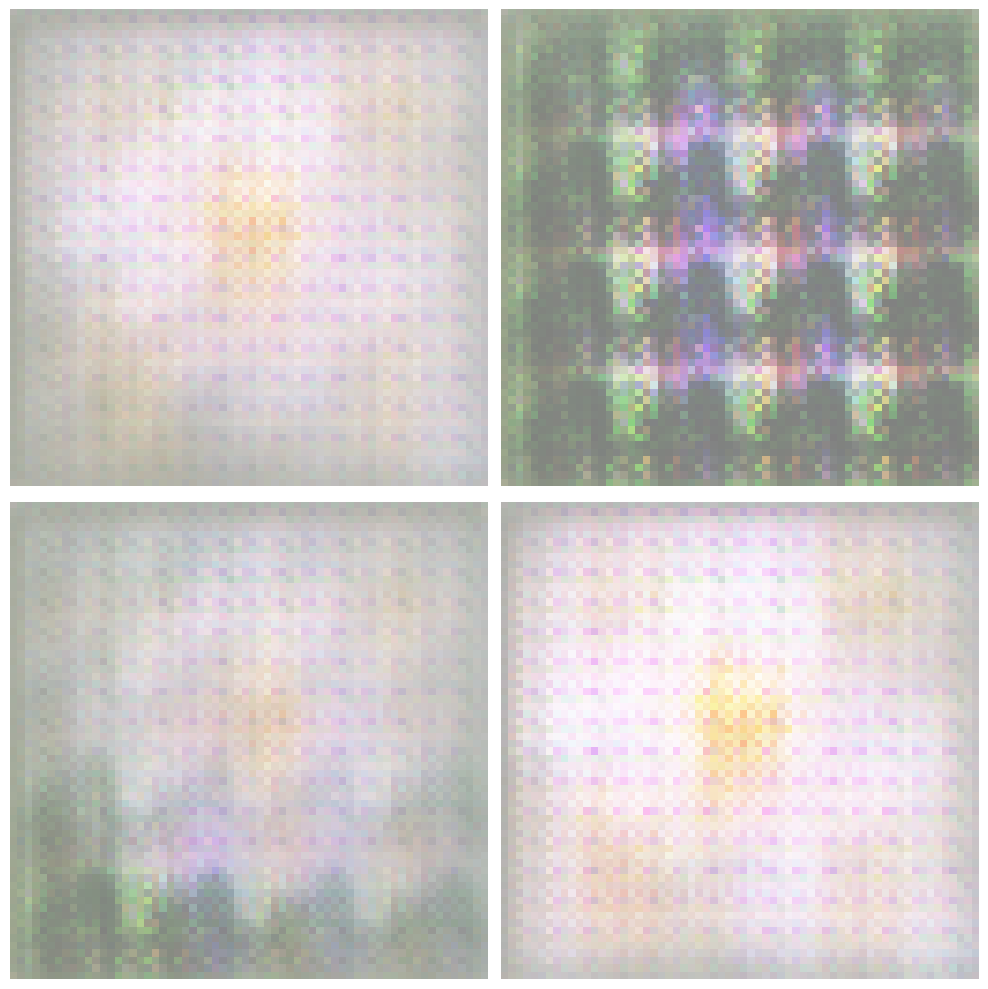

In [66]:
# Load the saved model and losses
loaded_generator, loaded_discriminator = load_models(save_dir, 'final')
loaded_gen_losses, loaded_disc_losses = load_losses(save_dir)

# Plot the losses
plot_losses(loaded_gen_losses, loaded_disc_losses)

# Evaluate the loaded model
is_mean, is_std, fid = evaluate_gan(loaded_generator, dataset)
print(f'Loaded Model Evaluation - Inception Score: {is_mean:.4f} ± {is_std:.4f}, FID: {fid:.4f}')

# Generate and display new images
new_images = generate_images(loaded_generator, 4, noise_dim, embedding_dim)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, img in enumerate(new_images):
    ax = axs[i//2, i%2]
    ax.imshow((img.numpy() + 1) * 0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Glove without Proofread

In [87]:
# Main execution
BATCH_SIZE = 64
noise_dim = 100
embedding_dir=r"C:\Dataset\embeddings_300_raw_glove"
# Determine embedding dimension
embedding_dim = get_embedding_dimension(embedding_dir)

# Create the models
generator = make_generator_model(noise_dim, embedding_dim)
discriminator = make_discriminator_model(embedding_dim)

# Prepare the dataset
dataset = FlowersDataset(
    image_dir=r"C:\Dataset\Images", 
    embedding_dir=r"C:\Dataset\embeddings_300_raw_glove",
    batch_size=BATCH_SIZE
)

# We'll reuse this seed and fixed embeddings to visualize progress
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
fixed_embeddings = tf.random.normal([num_examples_to_generate, embedding_dim])

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
save_dir= r'Model_glove_raw_500'
epochs=500

In [88]:
# Start training
generator_losses, discriminator_losses = train(dataset,epochs=epochs, save_dir=save_dir, eval_interval=100)

Epoch 1, Gen Loss: 0.9017, Disc Loss: 0.7368
Epoch 2, Gen Loss: 2.0227, Disc Loss: 0.2207
Epoch 3, Gen Loss: 2.3418, Disc Loss: 0.1643
Epoch 4, Gen Loss: 2.8438, Disc Loss: 0.1178
Epoch 5, Gen Loss: 3.0306, Disc Loss: 0.1102
Epoch 6, Gen Loss: 2.8839, Disc Loss: 0.1379
Epoch 7, Gen Loss: 3.1506, Disc Loss: 0.1902
Epoch 8, Gen Loss: 3.0066, Disc Loss: 0.2233
Epoch 9, Gen Loss: 2.9939, Disc Loss: 0.1881
Epoch 10, Gen Loss: 3.8979, Disc Loss: 0.1056
Epoch 11, Gen Loss: 3.7838, Disc Loss: 0.0577
Epoch 12, Gen Loss: 4.2482, Disc Loss: 0.0493
Epoch 13, Gen Loss: 3.6955, Disc Loss: 0.0668
Epoch 14, Gen Loss: 4.0643, Disc Loss: 0.0678
Epoch 15, Gen Loss: 4.2879, Disc Loss: 0.0506
Epoch 16, Gen Loss: 4.7668, Disc Loss: 0.0491
Epoch 17, Gen Loss: 4.7732, Disc Loss: 0.0508
Epoch 18, Gen Loss: 4.8005, Disc Loss: 0.0338
Epoch 19, Gen Loss: 4.8206, Disc Loss: 0.0192
Epoch 20, Gen Loss: 5.0416, Disc Loss: 0.0176
Epoch 21, Gen Loss: 5.1792, Disc Loss: 0.0200
Epoch 22, Gen Loss: 5.1026, Disc Loss: 0.03

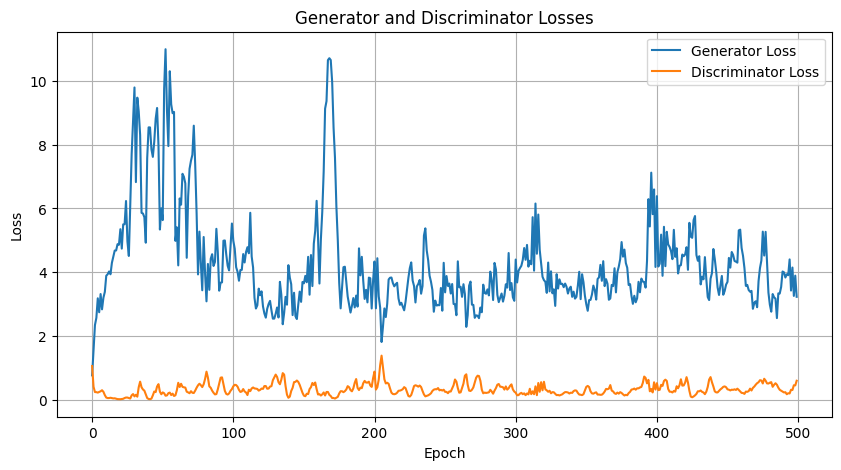

32/32 [==============================] - 17s 536ms/step
Loaded Model Evaluation - Inception Score: 29722342.0000 ± 21500020.0000, FID: 7.5565


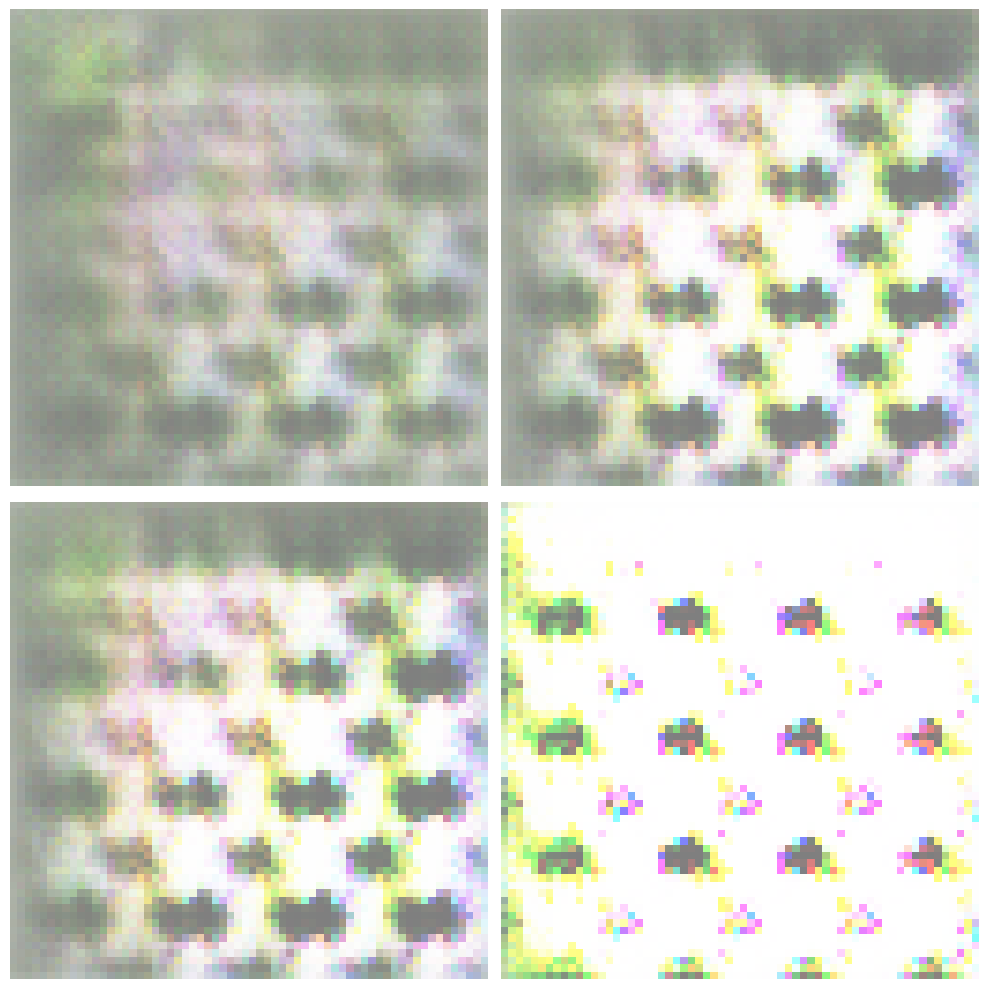

In [89]:
# Load the saved model and losses
loaded_generator, loaded_discriminator = load_models(save_dir, 'final')
loaded_gen_losses, loaded_disc_losses = load_losses(save_dir)

# Plot the losses
plot_losses(loaded_gen_losses, loaded_disc_losses)

# Evaluate the loaded model
is_mean, is_std, fid = evaluate_gan(loaded_generator, dataset)
print(f'Loaded Model Evaluation - Inception Score: {is_mean:.4f} ± {is_std:.4f}, FID: {fid:.4f}')

# Generate and display new images
new_images = generate_images(loaded_generator, 4, noise_dim, embedding_dim)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, img in enumerate(new_images):
    ax = axs[i//2, i%2]
    ax.imshow((img.numpy() + 1) * 0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()